## TODO:
- Try to switch to DFA from here and check the performance results.

In [1]:
import numpy as np
import math
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose

In [2]:
from scripts.train import *

In [3]:
print(torch.__version__)
print(np.__version__)

1.9.0
1.20.3


## Create Parity Data Iterator

In [4]:
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

In [5]:
# doesn't perform and transformation until we call the loader
trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transforms)
testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transforms)

/home/john/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## MLP Scratch

In [6]:
learn_rate = 0.05
num_epochs = 20
batch_size = 128
loss_fn = torch.nn.BCELoss() # or BCELoss with sigmoid activation in last layer

In [7]:
class MLP_Manual(torch.nn.Module):
    def __init__(self, k, device, batch_size, loss_type = "Cross Entropy"):
        super().__init__()

        self.batch_size = batch_size
        self.input_dim = 28 * 28 * k
        self.hidden_dim = 512
        if loss_type == "Cross Entropy":
            self.output_dim = 2
        else:                           # BCE case
            self.output_dim = 1
        self.learning_rate = 0.001
        self.flat = torch.nn.Flatten() # when input comes as 28x28, this'll convert to 784
        # WEIGHTS
        # initialize the weights as pytorch does by default --> IT DIVERGES and perform worse (90%) for k=1
        # e.g. 784 x 512
        self.w1 = torch.empty(self.input_dim, self.hidden_dim).to(device)
        stdv1 = 1. / math.sqrt(self.w1.size(1))
        self.w1.uniform_(-stdv1, +stdv1)
        #  e.g. 512 x 1
        self.w2 = torch.empty(self.hidden_dim, self.output_dim).to(device)
        stdv2 = 1. / math.sqrt(self.w2.size(1))
        self.w2.uniform_(-stdv2, +stdv2)

        # BIASES
        self.b1 = torch.empty(batch_size, self.hidden_dim).to(device)
        self.b1.uniform_(-stdv1, stdv1)
        self.b2 = torch.empty(batch_size, self.output_dim).to(device)
        self.b2.uniform_(-stdv1, stdv1)


    @staticmethod
    def softmax(x):
        maxes = torch.max(x, 1, keepdim=True)[0]
        x_exp = torch.exp(x-maxes)
        x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
        return x_exp/x_exp_sum

    @staticmethod
    def sigmoid(s):
        return 1 / (1 + torch.exp(-s))

    @staticmethod
    def reLU(s):
        s[s < 0] = 0
        return s.float()

    @staticmethod
    def reLUPrime(s):
        s[s < 0] = 0
        s[s > 0] = 1
        return s.float()

    # Forward propagation
    def forward(self, X):

        X = self.flat(X)
        # batch_size changes at the end of the apoch from 128 to 96, this spawned a problem in calculations 
        self.dynamic_batch_size =  X.shape[0]  
        # a_k = W_k @ h_{k-1} + b_k, h_k = f(a_k) where h_0 = X and f is the non linearity, a_2 = y^
        self.a1 = torch.matmul(X, self.w1) + self.b1[:self.dynamic_batch_size, :] # e.g. k=1 --> 128x784 @ 784x512 + 128x512 where 128 is batch_size (X.shape[1])
        self.h1 = self.reLU(self.a1)       # f is the reLU
        self.a2 = torch.matmul(self.h1, self.w2) + self.b2[:self.dynamic_batch_size, :]

        if loss_type == "Cross Entropy":
            y_hat = torch.nn.functional.softmax(self.a2, dim=1)
        else:
            y_hat = self.sigmoid(self.a2)

        return y_hat # some loss functions handle output layer non-linearity

    # Backward propagation
    def backward(self, X, y, y_hat):
        X = self.flat(X)
        # gradients of W2 --> dBCE/dW2 = dE/dy^.dy^/da2. da2/dW2 = (y^ - y) h1
        if loss_type == "Cross Entropy":
            self.e = y_hat - torch.nn.functional.one_hot(y) # e - 128x2, h1.t - 512,128 for k=1
        else:
            self.e = y_hat - y.reshape(len(y),1) # e - 128x1, h1.t - 512,128 for k=1

        self.w2_grads = torch.matmul(self.h1.t(), self.e)
        # gradients of W1 --> dBCE/dW1 = dE/dh1 . dh1/da1 . da1/dW1
        # where dE/dh1 = dE/dy^ . dy^/da2 . da2/dh1
        self.dBCE_da1 = torch.matmul(self.e, self.w2.t()) * self.reLUPrime(self.a1) # e - 128x1, w2.t - 1,512 , a1 - 128,512
        self.w1_grads = torch.matmul(X.t(), self.dBCE_da1) # x.t - 784,128, dBCE_da1 128,512
        # gradients of b2 --> dBCE/db2 = dBCE/dy^. dy^/da2. da2/db2 = (y^-y)*1
        self.b2_grads = self.e[:self.dynamic_batch_size, :]
        # gradients of b1 --> dBCE/db1 = dBCE/dh1. dh1/da1. da1/db1
        # where dBCE/dh1 = dBCE/dy^ . dy^/da2 . da2/dh1
        self.b1_grads = self.dBCE_da1[:self.dynamic_batch_size, :]

        # Implement SGD here
        self.w1 -= self.learning_rate * self.w1_grads
        self.w2 -= self.learning_rate * self.w2_grads
        self.b1[:self.dynamic_batch_size, :] -= self.learning_rate * self.b1_grads
        self.b2[:self.dynamic_batch_size, :] -= self.learning_rate * self.b2_grads

    def train(self, X, y):
        # Forward propagation
        y_hat = self.forward(X)
        # Backward propagation and gradient descent
        self.backward(X, y, y_hat)

In [8]:
k=1
device="cpu"
loss_type = "Binary Cross Entropy"
model = MLP_Manual(k, device,batch_size, loss_type)

trainLostList, trainAccList, valLossList, valAccList  = train_model_manually(model, k, trainset, testset, loss_type, loss_fn, num_epochs,
                                                                             batch_size, validate_model = True, device=device)


Epoch 1 completed. Loss - total: 20010.1934 - average: 0.3335; Performance: 0.9557
TESTING - loss 690.8201930373907 - performance 0.9768
Epoch 2 completed. Loss - total: 3316.9260 - average: 0.0553; Performance: 0.9819
TESTING - loss 547.863657400012 - performance 0.9811
Epoch 3 completed. Loss - total: 2419.2156 - average: 0.0403; Performance: 0.9877
TESTING - loss 480.4453903287649 - performance 0.9840
Epoch 4 completed. Loss - total: 1895.4167 - average: 0.0316; Performance: 0.9906
TESTING - loss 442.6611929330975 - performance 0.9852
Epoch 5 completed. Loss - total: 1516.5449 - average: 0.0253; Performance: 0.9930
TESTING - loss 420.0097963921726 - performance 0.9861
Epoch 6 completed. Loss - total: 1227.7548 - average: 0.0205; Performance: 0.9945
TESTING - loss 408.0433516036719 - performance 0.9866
Epoch 7 completed. Loss - total: 1004.3724 - average: 0.0167; Performance: 0.9959
TESTING - loss 401.07751335017383 - performance 0.9860
Epoch 8 completed. Loss - total: 834.0473 - ave

In [17]:
k=3
device="cpu"
loss_type = "Binary Cross Entropy"
model2 = MLP_Manual(k, device,batch_size, loss_type)

trainLostList3, trainAccList3, valLossList3, valAccList3  = train_model_manually(model2, k, trainset, testset, loss_type, loss_fn, num_epochs,
                                                                             batch_size, validate_model = True, device=device)

Epoch 1 completed. Loss - total: 54931.1719 - average: 0.9155; Performance: 0.5003
TESTING - loss 6918.704738616943 - performance 0.5087
Epoch 2 completed. Loss - total: 40778.1250 - average: 0.6796; Performance: 0.5423
TESTING - loss 6622.054738998413 - performance 0.5723
Epoch 3 completed. Loss - total: 37897.6172 - average: 0.6316; Performance: 0.6192
TESTING - loss 6015.85560131073 - performance 0.6613
Epoch 4 completed. Loss - total: 35617.6133 - average: 0.5936; Performance: 0.6594
TESTING - loss 5738.1581954956055 - performance 0.6777
Epoch 5 completed. Loss - total: 34371.6875 - average: 0.5729; Performance: 0.6796
TESTING - loss 5580.632762908936 - performance 0.6939
Epoch 6 completed. Loss - total: 33809.2617 - average: 0.5635; Performance: 0.6876
TESTING - loss 5593.15292263031 - performance 0.6889
Epoch 7 completed. Loss - total: 33217.5508 - average: 0.5536; Performance: 0.6976
TESTING - loss 5395.530825614929 - performance 0.7078
Epoch 8 completed. Loss - total: 32819.007

In [18]:
SGD_k1_pytorch = []
with open("SGD_k1_pytorch.txt") as f1:
    for line in f1:
        SGD_k1_pytorch.append(float(line.strip()))

SGD_k3_pytorch = []
with open("SGD_k3_pytorch.txt") as f2:
    for line in f2:
        SGD_k3_pytorch.append(float(line.strip()))

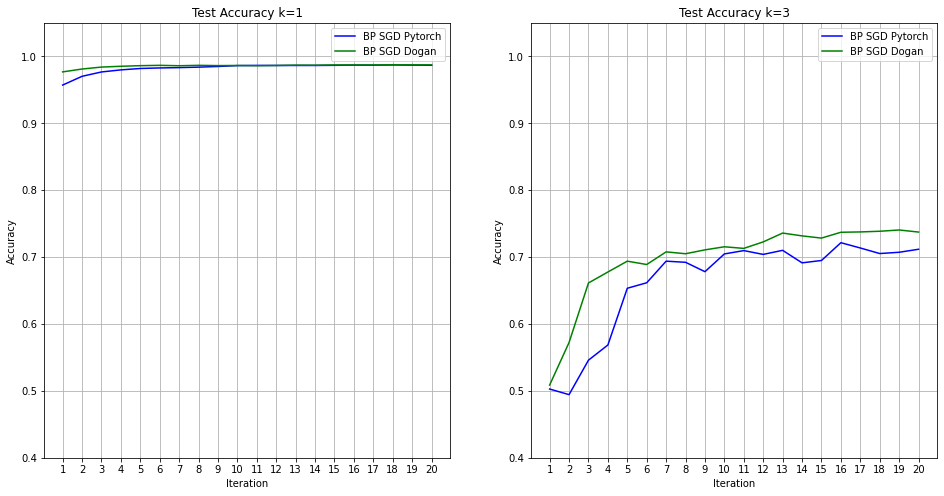

In [21]:
import matplotlib.pyplot as plt
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16,8))

ax1.plot(range(1,21),SGD_k1_pytorch, color = "blue", label = "BP SGD Pytorch") 
ax1.plot(range(1,21),valAccList, color = "green", label = "BP SGD Dogan")
ax1.set_ylim(0.4,1.05)
ax1.set_title("Test Accuracy k=1")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Accuracy")
ax1.set_xticks(range(1,21))
ax1.legend()
ax1.grid(True)


ax3.plot(range(1,21),SGD_k3_pytorch, color = "blue", label = "BP SGD Pytorch")
ax3.plot(range(1,21),valAccList3, color = "green", label = "BP SGD Dogan")

ax3.set_ylim(0.4,1.05)
ax3.set_title("Test Accuracy k=3")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Accuracy")
ax3.set_xticks(range(1,21))
ax3.legend()
ax3.grid(True)

plt.show();